In [1]:
import IPython.display
from ppget.source import DataSource
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

A_DAY = 60 * 24
DAYS_OF_DATA = 90

# [step] marks the percentage of time advance proportional to the data cursor [size]
source = DataSource("./data/household_power_consumption.txt", size=DAYS_OF_DATA * A_DAY, step=0.33)

# Empty, initialized iterator
source.frame.head()

""


In [2]:
from ppget.model import Model

WINDOW = 48
MODEL_TYPE = "gru"

model = Model(name="test", model_type=MODEL_TYPE, window=WINDOW)
model.compile()
model.describe()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 4)                 84        
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 13)                65        
                                                                 
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________


In [3]:
frame = next(source)
# window groups a measurements into a vector of size [sequence_length]
window = frame.generate_window(train_test_split=0.9, sequence_length=WINDOW)

# Data is normalized per window [not global!]
X_train, y_train = window.train_data(True)
X_test, y_test = window.test_data(True)
print(f"{X_train.shape} {X_test.shape}")

2006-12-16 17:20:00 -> 2007-03-16 17:20:00
(23268, 47, 1) (2533, 47, 1)


In [4]:
%%time
BATCH_SIZE = 32

model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE)

IPython.display.clear_output()

CPU times: user 14min 12s, sys: 5min 22s, total: 19min 34s
Wall time: 8min 32s


In [5]:
%%time
predictions = model.predict(X_test)

80/80 [==============================] - 1s 5ms/step
CPU times: user 1.53 s, sys: 231 ms, total: 1.76 s
Wall time: 1.2 s


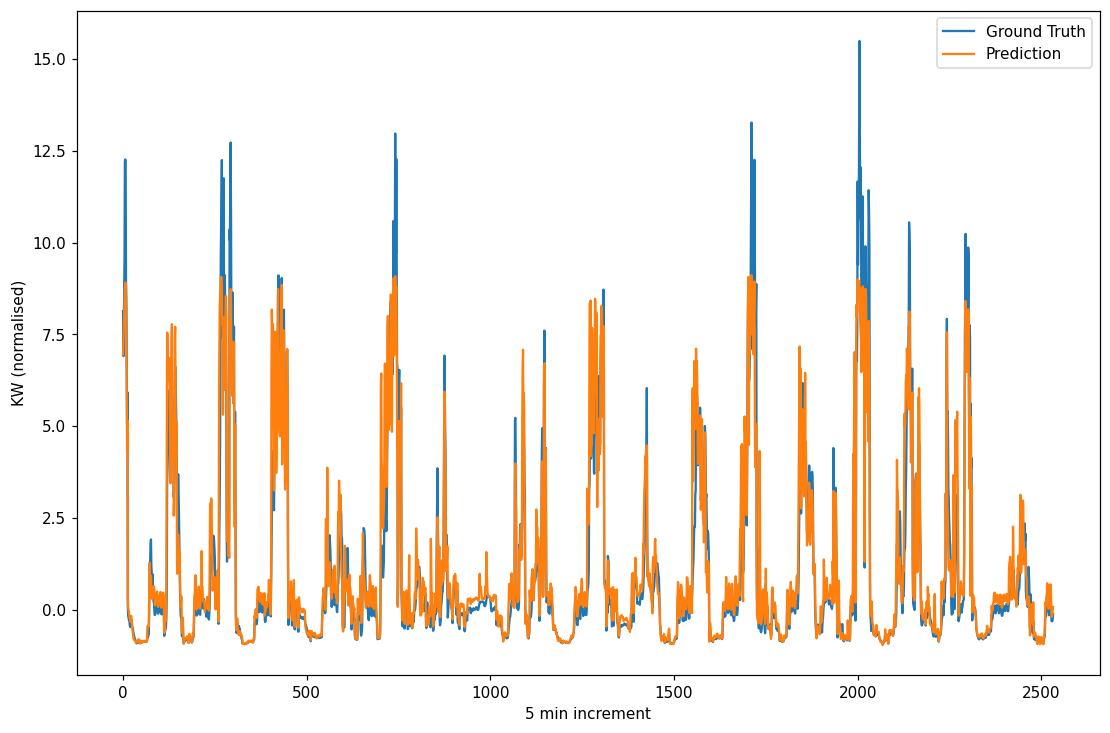

In [6]:
from ppget.reports import report_results

r2 = report_results(y_test, predictions, MODEL_TYPE, WINDOW)

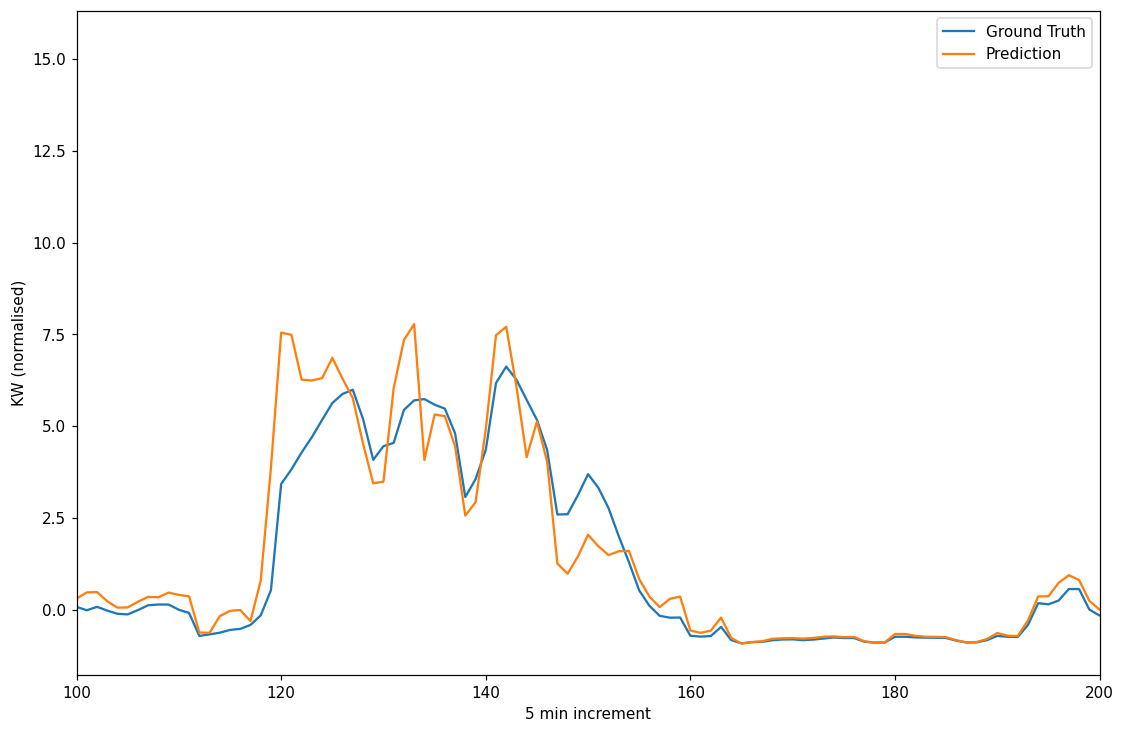

In [7]:
_ = report_results(y_test, predictions, MODEL_TYPE, WINDOW, range_limit=[100, 200])

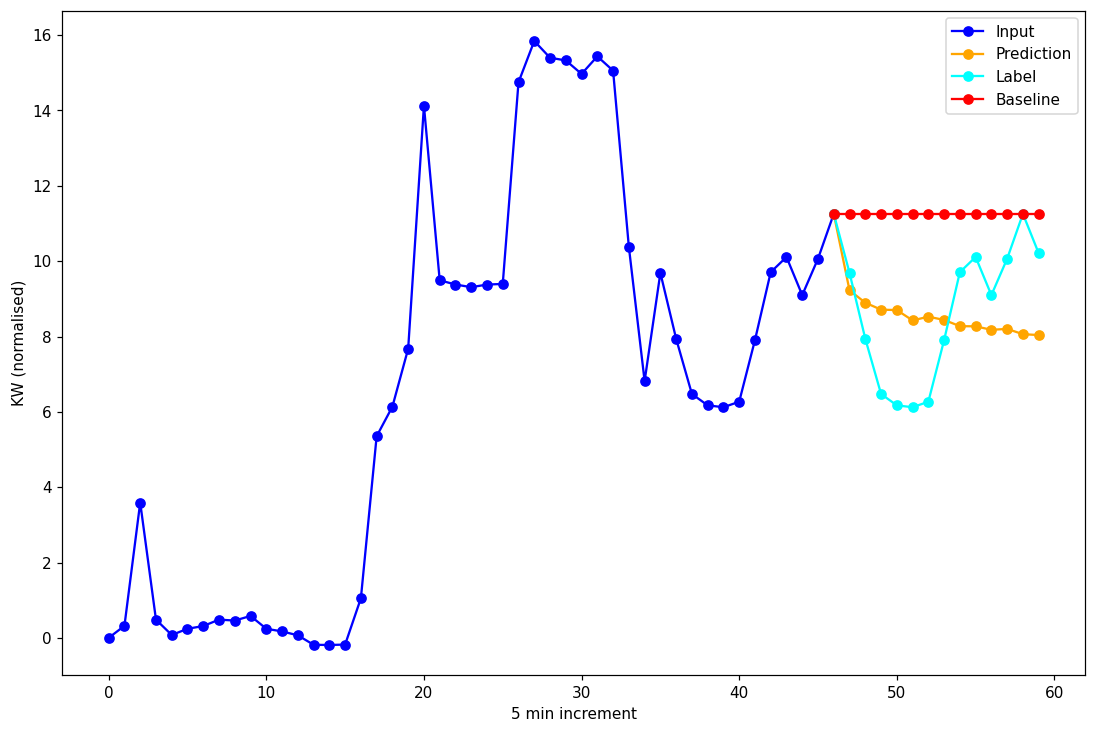

Case(2017): MSE (baseline) 10.42065597, MSE (gru) 3.68514707
P Value (baseline x gru): 0.00000000


In [8]:
from ppget.reports import report_best_case

best_case, mse_baseline, mse_model, p_value = report_best_case(X_test, y_test, predictions, MODEL_TYPE)

print(f"Case({best_case}): MSE (baseline) {mse_baseline:.8f}, MSE ({MODEL_TYPE}) {mse_model:.8f}\nP Value (baseline x {MODEL_TYPE}): {p_value:.8f}")

In [9]:
print(f"R2: {r2}")

R2: 0.8790217056666095


In [10]:
from ppget.reports import report_model_size

size = report_model_size(f"model/test-{MODEL_TYPE}")

print(f"Size({MODEL_TYPE}): {size/1024:.3f} KB")

Size(gru): 663.670 KB
